In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import re
import nltk.data
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob
from math import log
import string
from statistics import mean
from random import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/airline_sentiment_analysis.csv')

In [ ]:
train

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...,...
11536,14633,negative,@AmericanAir my flight was Cancelled Flightled...
11537,14634,negative,@AmericanAir right on cue with the delays👌
11538,14635,positive,@AmericanAir thank you we got on a different f...
11539,14636,negative,@AmericanAir leaving over 20 minutes Late Flig...


In [ ]:
nltk.download([
"stopwords",
"vader_lexicon",
"punkt",
'wordnet'
])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Sentiment analysis using Vader with no Preprocessing

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
predict=[]
for i in range(len(train["text"])):
  scores=sia.polarity_scores(train["text"][i])
  if(scores['pos']>=scores['neg']):
    predict.append(1)
  else:
    predict.append(0)
y=(train['airline_sentiment']=='positive')*1
print("Accuracy: ", sum(predict==y)/len(predict), " and F1 Score: ",f1_score(predict,y))

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Accuracy:  0.59986136383329  and F1 Score:  0.4958515283842795


Preprocessing

In [ ]:
y=(train['airline_sentiment']=='positive')*1

In [ ]:
words = open("/content/drive/MyDrive/words-by-frequency.txt").read().split()
wordcost = dict((k, log((i+1)*log(len(words)))) for i,k in enumerate(words))
maxword = max(len(x) for x in words)

def infer_spaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return list(reversed(out))

In [ ]:
pip install symspellpy

     |████████████████████████████████| 2.6 MB 35.2 MB/s 


In [ ]:
import pkg_resources
from symspellpy import SymSpell, Verbosity
sym_spell = SymSpell(max_dictionary_edit_distance=5, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [ ]:
pip install emot

In [ ]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [ ]:
class ProcessText():

  def SentenceSegmentation(self, text):
    tokenizer_punkt = nltk.data.load('tokenizers/punkt/english.pickle')
    segmentedText = tokenizer_punkt.tokenize(text.strip())
    return segmentedText

  def Tokenization(self, text):
      tokenizedText = []
      # APPOSTOPHES = {"'s" : "is", "'re" : "are", "'t": " not", "'ve": "have", "cause": "because", "'d": "would", "'ll": "will"} 
      p_t = nltk.tokenize.treebank.TreebankWordTokenizer()
      for i in text:
          text_raw_token = p_t.tokenize(i)
          for j in text_raw_token :
              if (j == "") or (j in string.punctuation):
                  continue
              tokenizedText.append(j)
      return tokenizedText
  
  def StopwordRemoval(self, text):
    stopwordRemovedText = None
    stop_words = set(stopwords.words('english')) 
    stopwordRemovedText = [j for j in text if not j in stop_words and len(j)>2]
    if(len(stopwordRemovedText)>0):
      return stopwordRemovedText
    else:
      return text

  def InflectionReduction(self,text):
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    reducedText = [lem.lemmatize(lem.lemmatize(j,'n'),'v') for j in text]
    return reducedText

  def process(self,texts):
    ptw=[]
    pts=[]
    for text in texts:
      emojiless=convert_emojis(text) #Converts Emojis into text
      linkless=re.sub(r'http\S+', '', emojiless) #Removes links
      d=re.sub(r'@\S+','',linkless) #Removes name
      # d = str(sym_spell.lookup_compound(d, max_edit_distance=2)[0])[:-6] # Spelling Correction
      d=self.SentenceSegmentation(str(d).lower()) #Sentence Segmentation
      for i in range(len(d)):
        for char in d[i]:
          if char =="_":
            d[i]=d[i].replace(char,' ')
          elif not char.isalpha():
            d[i]=d[i].replace(char,' ')
          else:
            d[i]=d[i]
      d1=self.Tokenization(d)
      d2=[]
      for i in range(len(d1)):
        d2=d2+(infer_spaces(d1[i]))
      for i in range(len(d2)):
        d2[i]=str(sym_spell.lookup(d2[i], Verbosity.CLOSEST, max_edit_distance=5,include_unknown=True)[0]).split(",")[0]
      d2=self.StopwordRemoval(d2)
      d3=self.InflectionReduction(d2)
      d4=' '.join(d3)
      ptw.append(d3)
      pts.append(d4)
    return ptw,pts
ptf=ProcessText()
print(ptf.process(train['text'][11:12]))

([['great', 'dismay', 'schedule', 'still', 'mia']], ['great dismay schedule still mia'])


In [ ]:
ptf=ProcessText()
x1,x2=ptf.process(train['text'])
word_list=list(set([word for text in x1 for word in text]))

In [ ]:
len(word_list)

5538

In [ ]:
poslist=[]
neglist=[]
for i in range(len(y)):
  for sentence in nltk.sent_tokenize(str(train['text'][i])):
    for word in nltk.word_tokenize(sentence):
      if(y[i]==1):
        poslist.append(word)
      else:
        neglist.append(word)

In [ ]:
positive_words = [word for sent in poslist for word in sent]
negative_words = [word for sent in neglist for word in sent]

In [ ]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

In [ ]:
def extract_features(text):
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in top_100_positive:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers you'll use later don't work with negative numbers.
    features=[mean(compound_scores) + 1, mean(positive_scores),wordcount]

    return features

In [ ]:
xtrain = np.zeros((len(y),3))
for i in range(len(y)):
  xtrain[i]=extract_features(str(train['text'][i])) 

In [ ]:
def lossfunct(output,target):
    ln=(target==0).sum()
    lp=(target==1).sum()
    fp=((output==target) & (target==1)).sum()
    fn=((output==target) & (target==0)).sum()
    loss=(4*fp+fn)/(4*lp+ln)
    return loss

In [ ]:
classifiers = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=2000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
for name, sklearn_classifier in classifiers.items():SklearnClassifier' object has no attribute 'test'
  kf = KFold(n_splits=5)
  accuracy = 0
  fscore = 0
  roc=0
  for train_index, test_index in kf.split(xtrain):
      X_train, X_test = xtrain[train_index], xtrain[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = sklearn_classifier
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      accuracy += lossfunct(y_pred, y_test)
      fscore += f1_score(y_pred, y_test)
      roc+=roc_auc_score(y_pred,y_test)
  print(name," Accuracy: ",accuracy/5, "F-score: ", fscore/5,"ROC_AUC:", roc/5)

KNeighborsClassifier  Accuracy:  0.7482099404934555 F-score:  0.6007362932864767 ROC_AUC: 0.7725242541726699
DecisionTreeClassifier  Accuracy:  0.7331668657903863 F-score:  0.5649427784302745 ROC_AUC: 0.7385016851046163
RandomForestClassifier  Accuracy:  0.7560592364590673 F-score:  0.6136647171487857 ROC_AUC: 0.7758721197612303
LogisticRegression  Accuracy:  0.7338499911449959 F-score:  0.5940924733570749 ROC_AUC: 0.7922164147330049
MLPClassifier  Accuracy:  0.7419559794490402 F-score:  0.6065919363199892 ROC_AUC: 0.7956612934318227
AdaBoostClassifier  Accuracy:  0.7553569305569834 F-score:  0.6203045822568164 ROC_AUC: 0.7911018679716278


In [ ]:
poslist=[]
neglist=[]
for i in range(len(y)):
  if(y[i]==1):
    poslist.append(x1[i])
  else:
    neglist.append(x1[i])

In [ ]:
positive_words = [word for sent in poslist for word in sent]
negative_words = [word for sent in neglist for word in sent]

In [ ]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = {word for word, count in positive_fd.most_common(1000)}
top_100_negative = {word for word, count in negative_fd.most_common(1000)}

In [401]:
def extract_features(text):
    poswordcount = 0
    negwordcount = 0
    compound_scores = list()
    positive_scores = list()
    negative_scores = list()
    neutral_scores = list()
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in top_100_positive:
              poswordcount += 1
            elif word.lower() in top_100_negative:
              negwordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])
        # negative_scores.append(sia.polarity_scores(sentence)["neg"])
        # neutral_scores.append(sia.polarity_scores(sentence)["neu"])
    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers you'll use later don't work with negative numbers.
    features=[mean(compound_scores) + 1, mean(positive_scores),poswordcount,negwordcount]

    return features

In [402]:
xtrain = np.zeros((len(y),4))
for i in range(len(y)):
  xtrain[i]=extract_features(x2[i]) 

negcount

In [403]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
for name, sklearn_classifier in classifiers.items():
  kf = KFold(n_splits=5)
  accuracy = 0
  fscore = 0
  roc=0
  for train_index, test_index in kf.split(xtrain):
      X_train, X_test = xtrain[train_index], xtrain[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = sklearn_classifier
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      accuracy += lossfunct(y_pred, y_test)
      fscore += f1_score(y_pred, y_test)
      roc+=roc_auc_score(y_pred,y_test)
  print(name," Accuracy: ",accuracy/5, "F-score: ", fscore/5,"ROC_AUC:", roc/5)

KNeighborsClassifier  Accuracy:  0.8401973347379761 F-score:  0.7476393558346586 ROC_AUC: 0.8521159789247565
DecisionTreeClassifier  Accuracy:  0.8283764857318957 F-score:  0.7262229921090215 ROC_AUC: 0.8384798445076476
RandomForestClassifier  Accuracy:  0.8419086418638683 F-score:  0.7450842561911377 ROC_AUC: 0.8470407995892879
LogisticRegression  Accuracy:  0.8390317314227204 F-score:  0.7485538380051492 ROC_AUC: 0.8556341022189751
MLPClassifier  Accuracy:  0.8326320095831494 F-score:  0.7419464059934378 ROC_AUC: 0.8562063784280204
AdaBoostClassifier  Accuracy:  0.8461748742264767 F-score:  0.7641032140852542 ROC_AUC: 0.8685353893786438


In [406]:
torch.save(model,'/content/drive/MyDrive/enthirebestmodel.cpkt')

only poscount

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
for name, sklearn_classifier in classifiers.items():
  kf = KFold(n_splits=5)
  accuracy = 0
  fscore = 0
  roc=0
  for train_index, test_index in kf.split(xtrain):
      X_train, X_test = xtrain[train_index], xtrain[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = sklearn_classifier
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      accuracy += lossfunct(y_pred, y_test)
      fscore += f1_score(y_pred, y_test)
      roc+=roc_auc_score(y_pred,y_test)
  print(name," Accuracy: ",accuracy/5, "F-score: ", fscore/5,"ROC_AUC:", roc/5)

KNeighborsClassifier  Accuracy:  0.8141458412272099 F-score:  0.7121240343740114 ROC_AUC: 0.8381451382407065
DecisionTreeClassifier  Accuracy:  0.7966530183611289 F-score:  0.6782064608547658 ROC_AUC: 0.8144320221943259
RandomForestClassifier  Accuracy:  0.8106343221620843 F-score:  0.7041769313082576 ROC_AUC: 0.8329992370681586
LogisticRegression  Accuracy:  0.7934638068700385 F-score:  0.6962533629172004 ROC_AUC: 0.8545073988187358
MLPClassifier  Accuracy:  0.7950157454866602 F-score:  0.6993846231677863 ROC_AUC: 0.8565071261350932
AdaBoostClassifier  Accuracy:  0.8080145704945544 F-score:  0.712981674860125 ROC_AUC: 0.8532630570288167


LSTM Models

In [282]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import math
import pickle
import os
from scipy.stats import rv_discrete
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
df = train

In [300]:
tokenizer = Tokenizer(num_words=len(word_list), split=' ')
tokenizer.fit_on_texts(x1)
X = tokenizer.texts_to_sequences(x1)
X = pad_sequences(X)

In [388]:
trainloader=DataLoader(torch.tensor(X[:int(0.9*len(y))]),batch_size=500)
ytrain=Ytensor[:int(0.9*len(y))]
valloader=DataLoader(torch.tensor(X[int(0.9*len(y)):]),batch_size=500)
ytest=Ytensor[int(0.9*len(y)):]

In [285]:
np.shape(X)

(11541, 85)

In [395]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()
    self.emb=nn.Embedding(len(word_list),50)
    self.lstm = nn.LSTM(50,10)
    self.layer2 = nn.Linear(10, 2)
    
  def forward(self, X):
    X=self.emb(X)
    hiddenstate=torch.zeros(1,X.size(1),10)
    cellstate=torch.zeros(1,X.size(1),10)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) 
    # print(out.size())
    out = self.layer2(out[:,-1,:])
    # print(out.size())
    return out.reshape(-1,2)

In [294]:
Ytensor=torch.tensor(y)

In [396]:
learning_rate = 3e-3
epochs = 20
criterion2 = nn.CrossEntropyLoss()

In [397]:
trainingloss_list = []
validationloss_list = []
validationaccuracy_list = []

model2=LSTM()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [398]:
for epoch in range(epochs):
  for i, data in enumerate(trainloader):
    outputs = model2(data)
    # print(outputs.size())
    loss = criterion2(outputs, ytrain[i*500:i*500+500])
    trainingloss_list.append(loss.item())
    
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
  iteration=0
  tempvalloss=0
  correctval=0    
  
  for i, data in enumerate(valloader):
    outputs = model2(data)
    # print(outputs.size())
    loss = criterion2(outputs, ytest[i*500:i*500+500])
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == ytest[i*500:i*500+500]).sum().item()
    iteration+=1
    tempvalloss+=loss.item()
      
  validationloss_list.append(tempvalloss/iteration)
  validationaccuracy_list.append(correctval/len(ytest)*100)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 20 epochs are over
Epoch 2 out of 20 epochs are over
Epoch 3 out of 20 epochs are over
Epoch 4 out of 20 epochs are over
Epoch 5 out of 20 epochs are over
Epoch 6 out of 20 epochs are over
Epoch 7 out of 20 epochs are over
Epoch 8 out of 20 epochs are over
Epoch 9 out of 20 epochs are over
Epoch 10 out of 20 epochs are over
Epoch 11 out of 20 epochs are over
Epoch 12 out of 20 epochs are over
Epoch 13 out of 20 epochs are over
Epoch 14 out of 20 epochs are over
Epoch 15 out of 20 epochs are over
Epoch 16 out of 20 epochs are over
Epoch 17 out of 20 epochs are over
Epoch 18 out of 20 epochs are over
Epoch 19 out of 20 epochs are over
Epoch 20 out of 20 epochs are over


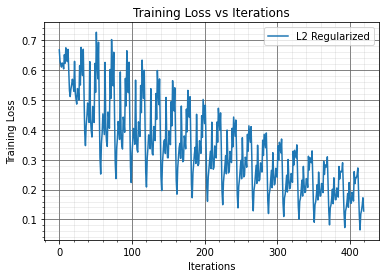

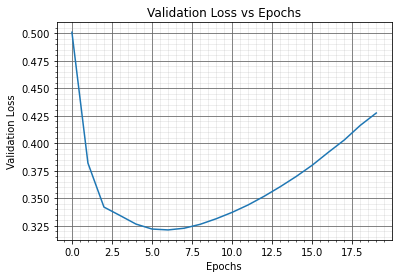

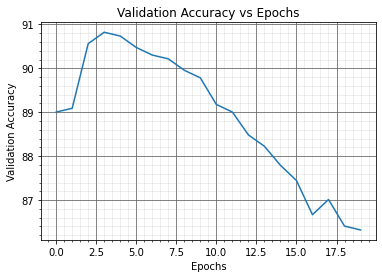

In [399]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list))
# plt.plot(xtrainloss,trainingloss_list,label="Unregularized")
plt.plot(xtrainloss,trainingloss_list,label="L2 Regularized")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')

plt.figure(2)
xvalloss=np.arange(len(validationloss_list))
plt.plot(xvalloss,validationloss_list)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')

plt.figure(3)
plt.plot(xvalloss,validationaccuracy_list)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')

plt.show()

In [400]:
with torch.no_grad():
  outputs=model2(torch.tensor(X[int(0.9*len(y)):]))
  _, predicted = torch.max(outputs.data, 1)
  print(lossfunct(predicted,ytest))

tensor(0.7331)
